In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

#%matplotlib notebook

import sklearn
import matplotlib as mpl
import seaborn as sns

import re

%matplotlib inline

pd.options.display.max_rows = 10

In [3]:
# Dataset

# use this if in fmi-hw... repo
# train = pd.read_csv("data/spooky/train.zip", index_col=['id'])
# test = pd.read_csv("data/spooky/test.zip", index_col=['id'])
# sample_submission = pd.read_csv("data/spooky/sample_submission.zip", index_col=['id'])

train = pd.read_csv("data/train.zip", index_col=['id'])
test = pd.read_csv("data/test.zip", index_col=['id'])
sample_submission = pd.read_csv("data/sample_submission.zip", index_col=['id'])


print(train.shape, test.shape, sample_submission.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1) (8392, 3)
{'author'}


In [4]:
train.head(5)

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


# Идеи за фичъри:
    
* CountVectorizer, Tfidf
* Preprocessing - stop words, lematization
* Други фичъри - бр. думи , бр. стоп думи, бр. пунктуация, бр. ГЛАВНИ букви и т.н.
* Намиране на общи теми чрез LDA
* Word Embeddings с невронни мрежи


# Първо - baseline модел

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

In [6]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LinearSVC())
])

cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3)

array([ 0.78783701,  0.79635305,  0.79509579])

In [7]:
from sklearn.model_selection import cross_val_predict
prediction = cross_val_predict(pipeline, train.text, train.author, cv=3, n_jobs=3)

In [8]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.793094642219


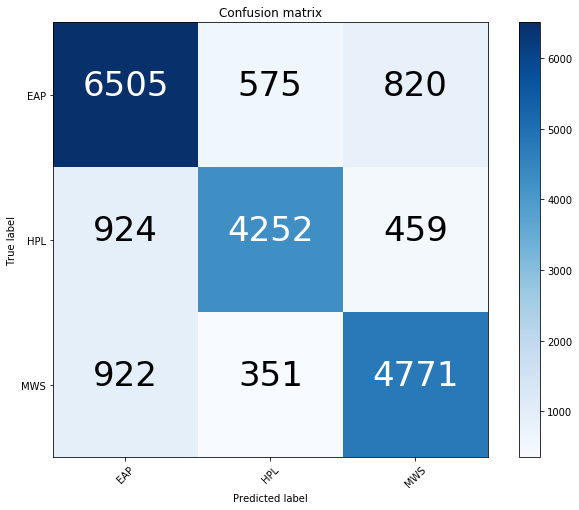

In [9]:
pipeline.fit(train.text, train.author)
authors = pipeline.classes_
print(accuracy_score(train.author, prediction))
plot_confusion_matrix(train.author, prediction, classes=authors)

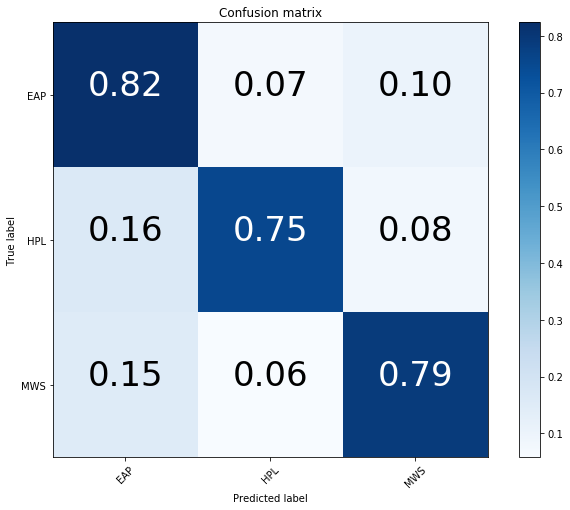

In [10]:
plot_confusion_matrix(train.author, prediction, classes=authors, normalize=True)

Да пробваме с RF

In [11]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

# print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
# print(cross_val_score(pipeline, train.text, train.author, 
#                 cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.62300858  0.61798958  0.60551724]

[-1.36418837 -1.38716468 -1.43783028]

In [12]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LogisticRegression())
])

# print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
# print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
#                       scoring='neg_log_loss'))

# Получихме малко по-добри резултати

[ 0.81449142  0.81673307  0.81348659]

[-0.47678328 -0.47558895 -0.47131481]

Следващото е за да имаме "explore" датасет

In [13]:
explore = train.copy()

In [14]:
# # бр. думи в текста
# explore['words'] = explore.text.apply(lambda s: len(str(s).split()))

# # бр. уникални думи
# explore['unique_words'] = explore.text.apply(lambda s: len(set(str(s).split())))

# # бр. символи
# explore['symbols'] = explore.text.str.len()

# # бр. уникални символи
# explore['unique_symbols'] = explore.text.apply(lambda s: len(set(str(s))))

# import string

# # бр. главни букви
# explore['capital_letters'] = explore.text.apply(lambda s: sum([str.isupper(c) for c in str(s)]))

# # бр. на думи съдържащи само главни буква
# explore['only_capital_letter_words'] = explore.text.apply(lambda s: sum([str.isupper(w) for w in str(s).split()]))

# # средна дължина на дума
# explore['average_word_lenght'] = explore.text.apply(lambda s: np.mean([len(w) for w in str(s).split()]))

# # бр. цифрите
# explore['digits'] = explore.text.apply(lambda s: sum([str.isdigit(c) for c in str(s)]))

# # бр. на препинателни знаци
# train["punctuation"] = train.text.apply(lambda s: sum([c in string.punctuation for c in str(s)]) )

In [17]:
import nltk
# nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

In [18]:
# features_names = list(set(explore.columns) - {'text', 'author'})
# print('numeric features', features_names)

In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stem = PorterStemmer()

explore['stemmed'] = explore.text.apply(lambda t: " ".join([stem.stem(w) for w in t.split()])) 

explore[['stemmed', 'text']].head()

,stemmed,text
id,,
id26305,"thi process, however, afford me no mean of asc...","This process, however, afforded me no means of..."
id17569,It never onc occur to me that the fumbl might ...,It never once occurred to me that the fumbling...
id11008,"In hi left hand wa a gold snuff box, from whic...","In his left hand was a gold snuff box, from wh..."
id27763,how love is spring As we look from windsor ter...,How lovely is spring As we looked from Windsor...
id12958,"find noth else, not even gold, the superintend...","Finding nothing else, not even gold, the Super..."


In [20]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LinearSVC())
])

cross_val_score(pipeline, explore.stemmed, train.author, cv=3, n_jobs=3)

# Резултати от същия pipeline използвайки колона text:
# array([ 0.78783701,  0.79635305,  0.79509579])

array([ 0.78477328,  0.78562672,  0.78482759])

# Допълнителните фичъри не сработиха, стеминга също. 

Остават да пробвам:

* Оптимизиране на модела с CountVectorizer.
* Добавяне на още фичъри, от латентни пространства (LDA) - topic modeling.
* Word embeddings с невронни мрежи.
* Стакинг на класификатори.

За сега ще разгледаме само оптимизирането на модела.

Първо да опишем параметрите за търсене в трансфомацията (CountVectorizer)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

params_count_word = {"features__ngram_range": [(1,1), (1,2), (1,3)],
                      "features__analyzer": ['word'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}

params_count_char = {"features__ngram_range": [(1,4), (1,5), (1,6)],
                      "features__analyzer": ['char'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                      "features__min_df":[2, 3, 5, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}

In [22]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
def random_search():
    params = {
        "clf__C": [0.01, 0.1, 0.3, 1, 3, 10],
        "clf__class_weight": [None, 'balanced']
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', CountVectorizer()),
        ('clf', LogisticRegression())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=2)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

# random_search()

== original ==

Model with rank: 1
Mean validation score: -0.475 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 1}

Model with rank: 2
Mean validation score: -0.482 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 1}

Model with rank: 3
Mean validation score: -0.486 (std: 0.001)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 3}

Model with rank: 4
Mean validation score: -0.508 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 0.3}

Model with rank: 5
Mean validation score: -0.525 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 0.3}


== local results ==

Model with rank: 1
Mean validation score: -0.474 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 1}

Model with rank: 2
Mean validation score: -0.513 (std: 0.002)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 2, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 3}

Model with rank: 3
Mean validation score: -0.515 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 0.3}

Model with rank: 4
Mean validation score: -0.547 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 1), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 0.3}

Model with rank: 5
Mean validation score: -0.547 (std: 0.004)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 3, 'features__max_df': 0.9, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 0.3}

# Tfidf = Term-frequency inverse document-frequency

* Идеята е да сложи тежести и значимост на всички думи или n-grams.
* Напр. "новина" е доста често срещана дума и може да бъде в различни контексти. 
* За разлика от "електроенцефалограф", която е много по-рядко срещана и директно дава медицински контекст.


* TF брои колко пъти се среща думата в текущия текст (пасаж, изречение, документ, семпъл).
* IDF брои колко пъти тази дума се среща изцяло в корпуса с които тренираме.

In [24]:
tfidf = TfidfVectorizer()

In [25]:
def random_search():
    params = {
        "clf__C": [0.01, 0.1, 0.3, 1, 3, 10],
        "clf__class_weight": [None, 'balanced']
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=2)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

# random_search() # предишния най-добър резултат:  -0.475 

== original ==

Model with rank: 1
Mean validation score: -0.469 (std: 0.005)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 1.0, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}

Model with rank: 2
Mean validation score: -0.471 (std: 0.006)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 3, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Model with rank: 3
Mean validation score: -0.483 (std: 0.008)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}

Model with rank: 4
Mean validation score: -0.495 (std: 0.002)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.6, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}

Model with rank: 5
Mean validation score: -0.522 (std: 0.005)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 10, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}


== local result ==

Model with rank: 1
Mean validation score: -0.468 (std: 0.005)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 1.0, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Model with rank: 2
Mean validation score: -0.484 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.7, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Model with rank: 3
Mean validation score: -0.484 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': 'balanced', 'clf__C': 10}

Model with rank: 4
Mean validation score: -0.488 (std: 0.008)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__min_df': 5, 'features__max_df': 0.7, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Model with rank: 5
Mean validation score: -0.495 (std: 0.004)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 3, 'features__max_df': 1.0, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__class_weight': None, 'clf__C': 10}

Има леко подобрение в `LogLoss`.

Да пробваме да сменим и класификатора с друг класически за класификация на текст: `Naive Bayes`

In [26]:
from sklearn.naive_bayes import MultinomialNB

def random_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=2)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

# random_search()  # Предишния най-добър резултат: -0.469

== original ==

Model with rank: 1
Mean validation score: -0.423 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 2
Mean validation score: -0.465 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 1), 'features__min_df': 3, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 3
Mean validation score: -0.469 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 5, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 4
Mean validation score: -0.495 (std: 0.002)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 5, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 5
Mean validation score: -0.496 (std: 0.004)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 3), 'features__min_df': 5, 'features__max_df': 0.6, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}


== local ==

Model with rank: 1
Mean validation score: -0.422 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 2, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 2
Mean validation score: -0.496 (std: 0.004)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 0.7, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 3
Mean validation score: -0.502 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 0.5, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 3
Mean validation score: -0.502 (std: 0.003)
Parameters: {'features__stop_words': yes, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 0.9, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Model with rank: 5
Mean validation score: -0.524 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 10, 'features__max_df': 0.7, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.1}

Тук има още подобрение в метриката.

Искам да го пробвам и със stemming.

Освен това се вижда, че избира най-ниската предоставена стойност за `alpha`, може би трябва да пробвам с още по-ниски.

In [27]:
def random_search():
    params = {
        "clf__alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 0.3]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(explore.stemmed, train.author)
    report(random_search.cv_results_)
    
# random_search()  # -0.423

Model with rank: 1
Mean validation score: -0.438 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.6, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 2
Mean validation score: -0.443 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 3, 'features__max_df': 0.6, 'features__lowercase': True, 'features__analyzer': 'word', 'clf__alpha': 0.05}

Model with rank: 3
Mean validation score: -0.453 (std: 0.002)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 2, 'features__max_df': 1.0, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 4
Mean validation score: -0.471 (std: 0.003)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 5, 'features__max_df': 1.0, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}

Model with rank: 5
Mean validation score: -0.472 (std: 0.004)
Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 3), 'features__min_df': 5, 'features__max_df': 0.5, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.05}


In [28]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Lambda, Concatenate
from keras.optimizers import RMSprop, Adam
from keras import regularizers, objectives, metrics
from keras.models import Model
from keras import backend as K

from IPython.display import display

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [29]:
from gensim import corpora, models, similarities

documents = train.text

In [30]:
# remove common words and tokenize
# stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stopwords] #was stoplist
         for document in documents]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

from pprint import pprint  # pretty-printer
pprint(texts[:10])

[['process,',
  'however,',
  'afforded',
  'means',
  'ascertaining',
  'dimensions',
  'might',
  'make',
  'return',
  'point',
  'whence',
  'set',
  'out,',
  'without',
  'aware',
  'perfectly',
  'uniform',
  'seemed',
  'wall.'],
 ['never', 'occurred', 'fumbling', 'might', 'mere', 'mistake.'],
 ['left',
  'hand',
  'gold',
  'snuff',
  'box,',
  'which,',
  'hill,',
  'cutting',
  'manner',
  'fantastic',
  'steps,',
  'took',
  'snuff',
  'incessantly',
  'air',
  'greatest',
  'possible',
  'self',
  'satisfaction.'],
 ['lovely',
  'spring',
  'looked',
  'windsor',
  'terrace',
  'sixteen',
  'fertile',
  'counties',
  'spread',
  'beneath,',
  'speckled',
  'happy',
  'cottages',
  'wealthier',
  'towns,',
  'looked',
  'former',
  'years,',
  'heart',
  'cheering',
  'fair.'],
 ['finding',
  'nothing',
  'else,',
  'even',
  'gold,',
  'superintendent',
  'abandoned',
  'perplexed',
  'look',
  'occasionally',
  'steals',
  'countenance',
  'sits',
  'thinking',
  'desk.']

In [31]:
import pickle

FILENAME = "processed_texts.pickle"

# create pickle
# pickle.dump(texts, open(FILENAME, "wb" ))

# depicke
texts = pickle.load(open(FILENAME, "rb"))

In [32]:
dictionary = corpora.Dictionary(texts)
dictionary.save('spooky.dict')  # store the dictionary, for future reference
print(len(dictionary))

22328


In [33]:
# corpus = [dictionary.doc2bow(text) for text in texts]
# corpora.MmCorpus.serialize('spooky.mm', corpus)  # store to disk, for later use

#restore from disk
corpus = corpora.mmcorpus.MmCorpus('spooky.mm')

In [34]:
tfidf = models.TfidfModel(corpus)

vec = [(0, 1), (4, 1)]
print(tfidf[vec])
# [(0, 0.8075244), (4, 0.5898342)]

[(0, 0.8349946498392148), (4, 0.5502580619490159)]


In [35]:
# from gensim import corpora, models, similarities

In [36]:
# index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)
index = similarities.docsim.Similarity('/home/bob/tmp', corpus, num_features=len(dictionary)) 

In [37]:
corpus[0]

[(0, 1.0),
 (1, 1.0),
 (2, 1.0),
 (3, 1.0),
 (4, 1.0),
 (5, 1.0),
 (6, 1.0),
 (7, 1.0),
 (8, 1.0),
 (9, 1.0),
 (10, 1.0),
 (11, 1.0),
 (12, 1.0),
 (13, 1.0),
 (14, 1.0),
 (15, 1.0),
 (16, 1.0),
 (17, 1.0),
 (18, 1.0)]

In [38]:
# sims = index[tfidf[corpus[0]]]
sims = index[corpus[0]]

In [39]:
results = list(enumerate(sims))

In [40]:
results[:5]

[(0, 0.99999982), (1, 0.093658581), (2, 0.0), (3, 0.0), (4, 0.0)]

In [48]:
from operator import itemgetter
    
top = sorted(results, key=itemgetter(1), reverse=True)[:5]
top

[(0, 0.99999982),
 (14771, 0.260133),
 (8578, 0.22941573),
 (12208, 0.22941573),
 (12524, 0.22941573)]

In [44]:
type(index)

gensim.similarities.docsim.Similarity

In [56]:
print('in df:     ', train.text[0],'\n')
print('as doc:    ', documents[0],'\n')
print('as tokens: ', texts[0],'\n')
print('as vec:    ', corpus[0],'\n')

in df:      This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. 

as doc:     This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. 

as tokens:  ['process,', 'however,', 'afforded', 'means', 'ascertaining', 'dimensions', 'might', 'make', 'return', 'point', 'whence', 'set', 'out,', 'without', 'aware', 'perfectly', 'uniform', 'seemed', 'wall.'] 

as vec:     [(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0)] 



In [61]:
print('unsorted sims to vec[0]', sims[:10])

unsorted sims to vec[0] [ 0.99999982  0.09365858  0.          0.          0.          0.          0.
  0.          0.03673591  0.        ]


In [64]:
print(documents[0])
for sim in top:
    print(sim[1], train.author[sim[0]], documents[sim[0]],'\n')

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
1.0 EAP This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. 

0.260133 EAP The expression of his smile, however, was by no means unpleasing, as might be supposed; but it had no variation whatever. 

0.229416 EAP Much, however, might be ascertained. 

0.229416 EAP I reapproached the wall. 

0.229416 HPL They seemed to hate and fear him at the same time, and he seemed to return these sentiments. 



-----------------------------------------------

-----------------------------------------------

-----------------------------------------------

-----------------------------------------------

-----------------------------------------------

-----------------------------------------------

In [42]:
fail here

SyntaxError: invalid syntax (<ipython-input-42-a2f04ec58aab>, line 1)

# Откри приблизително същите параметри, но не успя да стигне напълно до същия резултат.

Ще използвам следния модел:

TfIdf + MultinomialNB, без стеминг на текста.

Mean validation score: -0.423 (std: 0.003)

Ще ползвам и следните параметри:

Parameters: {'features__stop_words': None, 'features__ngram_range': (1, 2), 'features__min_df': 2, 'features__max_df': 0.8, 'features__lowercase': False, 'features__analyzer': 'word', 'clf__alpha': 0.01}


Последна проверка на този модел за `LogLoss` и `Accuracy`

In [ ]:
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1, 2), min_df=2,
                                 max_df=0.8, lowercase=False)),
    ('clf', MultinomialNB(alpha=0.01))
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

# Трениране на модел и събмит

Първо да видим в какъв формат трябва да се подадат резултатите за тест

In [ ]:
sample_submission = pd.read_csv("data/spooky-authors/sample_submission.zip")
sample_submission.head()

In [ ]:
pipeline = pipeline.fit(train.text, train.author)

In [ ]:
print(pipeline.predict_proba(test[:10].text))

In [ ]:
test_predictions = pipeline.predict_proba(test.text)

In [ ]:
print(pipeline.classes_)

In [ ]:
submit_file = pd.DataFrame(test_predictions, columns=['EAP', 'MWS', 'HPL'], index=test.index)
submit_file.head(10)

In [ ]:
submit_file.to_csv("data/spooky-authors/submit_Tfidf_MNB_text.csv")

Очакванията за събмита са да имаме скор някъде около 0.41 - 0.42.

Може да е малко по-добър защото при крос-валидацията тренирахме на 13к и тествахме 6к.

Сега трейн сета е целия: 19.5к

![submit-result.png](attachment:submit-result.png)

In [ ]:
# Да хакнем ранкинга в кагъл?

print(test.text[:5].values)